In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
from collections import namedtuple
import sys

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [88]:
np.set_printoptions(linewidth=160, precision=4)
# Avoid escaping any latex characters
tabulate.LATEX_ESCAPE_RULES = {}

MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

QUERY_ORDINAL_POSITION_COMORLAP= 'cool'
NUM_TIMES_TRAINED_COLORMAP = 'copper'

In [4]:
cache = analysis.refresh_cache()
print(cache.keys())

six_replications_analyses = cache['six_replications_analyses']
# query_mod_replications = cache['query_mod_replications']
control_analyses = cache['control_analyses']
six_replications_updated_analyses = cache['six_replications_updated_analyses']
control_updated_analyses = cache['updated_control_analyses']
query_mod_updated_analyses = cache['query_mod_updated_analyses']
task_conditional_analyses = cache['task_conditional_analyses']
task_conditional_multiplicative_only_analyses = cache['task_conditional_multiplicative_only_analyses']
task_conditional_additive_only_analyses = cache['task_conditional_additive_only_analyses']

dict_keys(['six_replications_analyses', 'control_analyses', 'query_mod_replications', 'six_replications_updated_analyses', 'updated_control_analyses', 'query_mod_updated_analyses', 'forgetting_curves_raw_data', 'preliminary_maml_analyses', 'baseline_maml_comparison_analyses', 'maml_analyses', 'maml_alpha_0_analyses', 'maml_meta_test_analyses', 'balanced_batches_analyses', 'baseline_total_curve_analyses', 'control_total_curve_analyses', 'query_mod_total_curve_analyses', 'simultaneous_training_analyses', 'per_task_simultaneous_training_analyses', 'task_conditional_analyses', 'task_conditional_multiplicative_only_analyses', 'task_conditional_additive_only_analyses', 'task_conditional_weights', 'task_conditional_multiplicative_only_weights', 'task_conditional_additive_only_weights', 'forgetting_exp_decay_params'])


## Making a note for myself to remember how  this worked

`mean[r, c]` is the mean examples to criterion for the task learned `r + 1` times when there are `c + 1` total tasks (that is, in episode `c + 1`). 

Thus, we can grab a column, and look at successive ratios, or something. Perhaps give a different color to the newest task?

In [12]:
mean = six_replications_analyses.combined.examples.mean

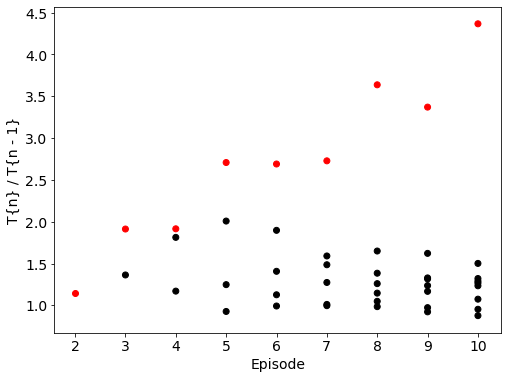

1.273808768717346 0.2779332309638774


In [36]:
plt.figure(figsize=(8, 6))

non_first_ratios = []

color_mapper = plt.get_cmap(NUM_TIMES_TRAINED_COLORMAP)
num_episodes = mean.shape[1]
for col in range(1, num_episodes):
    non_nan = mean[:, col]
    if np.any(np.isnan(non_nan)):
        non_nan = non_nan[:np.argmax(np.isnan(mean[:, col]))]

    ratios = non_nan[:-1] / non_nan[1:]
    non_first_ratios.extend(ratios[1:])
    colors = ['red'] + ['black'] * (col - 1)
#     colors = [color_mapper(i / num_episodes) for i in range(col)]
    plt.scatter(np.ones_like(ratios) * (col + 1), ratios, c=colors)
    

plt.xlabel('Episode')
plt.ylabel('T{n} / T{n - 1}')
    
plt.show()

print(np.mean(non_first_ratios), np.std(non_first_ratios))

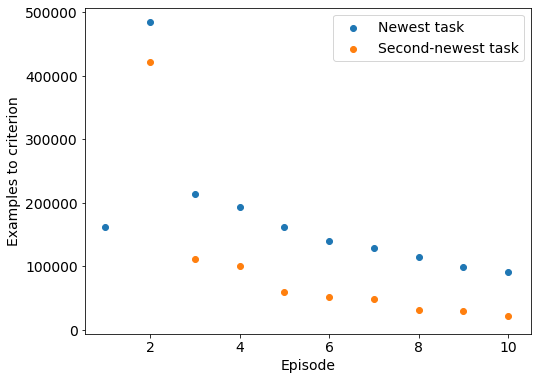

1.273808768717346 0.2779332309638774


In [39]:
plt.figure(figsize=(8, 6))

num_episodes = mean.shape[1]
plt.scatter(np.arange(num_episodes) + 1, mean[0, :], label='Newest task')
plt.scatter(np.arange(1, num_episodes) + 1, mean[1, 1:], label='Second-newest task')   

plt.xlabel('Episode')
plt.ylabel('Examples to criterion')
plt.legend(loc='best')
    
plt.show()


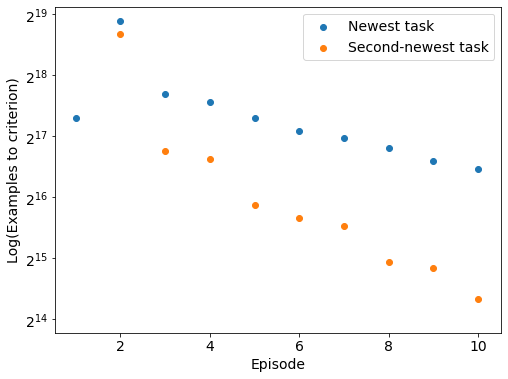

In [42]:
plt.figure(figsize=(8, 6))

num_episodes = mean.shape[1]
plt.scatter(np.arange(num_episodes) + 1, mean[0, :], label='Newest task')
plt.scatter(np.arange(1, num_episodes) + 1, mean[1, 1:], label='Second-newest task')   
plt.yscale('log', basey=2)
plt.xlabel('Episode')
plt.ylabel('Log(Examples to criterion)')
plt.legend(loc='best')
    
plt.show()


In [46]:
mean[0, 1:]

array([483750., 213125., 193125., 161875., 139750., 129125., 114625.,  99250.,  90000.])

In [55]:
np.nansum(mean[1:, 1:], axis=0)

array([421250.        , 193187.5       , 204000.        , 182156.25      , 163150.        , 165458.33333333, 130774.08888889, 115448.22222222,  97388.88888889])

In [56]:
mean[0, 1:] / np.nansum(mean[1:, 1:], axis=0)

array([1.14836795, 1.10320285, 0.94669118, 0.88866015, 0.85657371, 0.78040796, 0.87651155, 0.85969275, 0.92413006])

In [58]:
np.mean(mean[0, 1:] / np.nansum(mean[1:, 1:], axis=0)), np.std(mean[0, 1:] / np.nansum(mean[1:, 1:], axis=0))

(0.9315820174623334, 0.11316488532147183)

In [96]:
def curriculum_function(episode_number, task_number, ratio=1.25):
    if task_number > episode_number:
        raise ValueError(f'Cannot compute examples for a higher task number ({task_number}) than the episode number ({episode_number})')
        
    if episode_number == task_number:
        return 22500

    total_previous_task_examples = 50000 - 5000 - 22500
    last_previous_task_number = episode_number - 1
    first_task_examples = total_previous_task_examples / np.sum(np.power(ratio, range(last_previous_task_number)))

#     return np.around(first_task_examples * (1.25 ** (task_number - 1)))
    return first_task_examples * (ratio ** (task_number - 1))

In [97]:
for e in range(2, 11):
    print(sum([curriculum_function(e, t, 1.5) for t in range(1, e + 1)]))

45000.0
45000.0
45000.0
45000.0
45000.0
45000.0
45000.0
45000.0
45000.0


In [91]:
for e in range(2, 11):
    unrounded = np.array([curriculum_function(e, t) for t in range(1, e + 1)])
    rounded = np.around(unrounded)
    if sum(rounded) != sum(unrounded):
        print(sum(rounded), sum(unrounded), sum(rounded) == sum(unrounded))
        print(rounded)
        print(unrounded)
        print(unrounded - rounded)

45001.0 45000.0 False
[ 2742.  3427.  4284.  5355.  6693. 22500.]
[ 2741.5516  3426.9396  4283.6744  5354.5931  6693.2413 22500.    ]
[-0.4484 -0.0604 -0.3256 -0.4069  0.2413  0.    ]
44999.0 45000.0 False
[ 1493.  1866.  2332.  2915.  3644.  4555.  5694. 22500.]
[ 1492.6872  1865.859   2332.3237  2915.4047  3644.2558  4555.3198  5694.1498 22500.    ]
[-0.3128 -0.141   0.3237  0.4047  0.2558  0.3198  0.1498  0.    ]


In [69]:
np.power(1.25, range(3))

array([1.    , 1.25  , 1.5625])

In [95]:
for episode_number in range(2, 11):
    unrounded_coreset_sizes = np.array([curriculum_function(episode_number, task)
                                       for task in range(1, episode_number + 1)])
    rounded_coreset_sizes = np.around(unrounded_coreset_sizes)

    rounded_sum = np.sum(rounded_coreset_sizes)
    unrounded_sum = np.sum(unrounded_coreset_sizes)

    if rounded_sum != unrounded_sum:
        # Too many were rounded down, we need to increment.
        if rounded_sum < unrounded_sum:
            increment_index = np.argmax(unrounded_coreset_sizes - rounded_coreset_sizes)
            rounded_coreset_sizes[increment_index] += 1

        # Too many were rounded down, we need to decrement
        else:
            decrement_index = np.argmin(unrounded_coreset_sizes - rounded_coreset_sizes)
            rounded_coreset_sizes[decrement_index] -= 1
            
    print(episode_number, np.sum(rounded_coreset_sizes).astype(np.int))

2 45000
3 45000
4 45000
5 45000
6 45000
7 45000
8 45000
9 45000
10 45000


int